In [2]:
# Import required libraries
from openai import OpenAI
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [6]:
# Initialise API key and define embedding model
openai_api_key = "################################################"
EMBEDDING_MODEL = "text-embedding-ada-002"

In [4]:
# Load the dataset
import pandas as pd
reviews = pd.read_csv("womens_clothing_e-commerce_reviews.csv")

In [5]:
# Explore dataset: display the first few entries
reviews.head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [7]:
# Create and store embeddings for reviews
review_texts = reviews["Review Text"].dropna()

client = OpenAI(api_key=openai_api_key)

response = client.embeddings.create(
    model=EMBEDDING_MODEL,
    input=review_texts.to_list()
)

response_dict = response.model_dump()
embeddings = [data["embedding"] for data in response_dict['data']]

In [8]:
# Reduce embeddings to a 2-dimensional array using t-SNE model
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(np.array(embeddings))

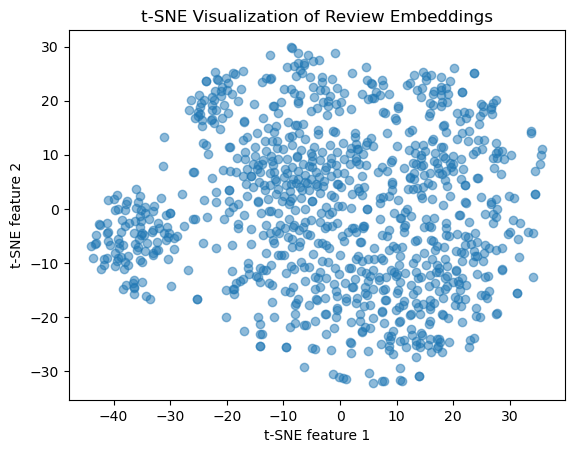

In [9]:
# Plot the 2D representation of the reviews
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], alpha=0.5)
plt.title("t-SNE Visualization of Review Embeddings")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.show()
plt.show()

In [10]:
# Create categories for review and create embeddings for categories
categories = ["quality", "fit", "style", "comfort"]

category_responses = client.embeddings.create(
    model=EMBEDDING_MODEL,
    input=categories
)

category_response_dict = category_responses.model_dump()
category_embeddings = [category["embedding"] for category in category_response_dict["data"]]

In [15]:
# Categorise reviews based on cosine distance
def find_category(review_embedding, category_embeddings):
    distances = []
    for index, embedding in enumerate(category_embeddings):
        dist = distance.cosine(review_embedding, embedding)
        distances.append({"distance": dist, "index": index})
    closest = min(distances, key=lambda x: x["distance"])
    return categories[closest["index"]]

feedback_categories = [find_category(embedding, category_embeddings) for embedding in embeddings]

In [16]:
# Define a function that outputs the closest 3 reviews to a given input review
def find_n_closest_reviews(review, embeddings, n=3):
    review_response = client.embeddings.create(
        model=EMBEDDING_MODEL, 
        input=review)
    
    review_response_dict = review_response.model_dump()
    
    review_embedding = review_response_dict['data'][0]['embedding']
    
    distances = []
    
    for index, embedding in enumerate(embeddings):
        dist = distance.cosine(review_embedding, embedding)
        distances.append({"distance": dist, "index": index})
    
    distances_sorted = sorted(distances, key=lambda x: x["distance"])
    return distances_sorted[0:n]

In [18]:
# Create the same function using Chromadb
import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

# Initialise Chromadb 
client = chromadb.PersistentClient()

# Define vector database
review_embeddings_db = client.create_collection(
    name="review_embeddings",
    embedding_function=OpenAIEmbeddingFunction(api_key=openai_api_key))

# Store embeddings inside vector database
review_embeddings_db.add(
    documents=review_texts.tolist(),
    ids=[str(i) for i in range(len(review_texts))]
)

# Function for similarity search using vector db query function
def find_n_closest_reviews(review, vector_db, n=3):
    collection = client.get_collection(
        name="review_embeddings",
        embedding_function=OpenAIEmbeddingFunction(api_key=openai_api_key))
    results = collection.query(
        query_texts=[review],
        n_results=n
    )
    return results